In [502]:
import time
#import retro
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from sklearn.preprocessing import scale
import numpy as np
import cv2
#import keyboard
import gym
import matplotlib.pylab as plt
from IPython.display import clear_output
#retro.data.list_games()

In [503]:
#obs, rew, done, info = env.step(env.action_space.sample())
#(224, 240, 3)
#MultiBinary(9)                          
class RAM_ANN():
  def __init__(self, action_space, frameskip, seed):
    self.seed = seed
    initializer1 = initializers.GlorotUniform (seed = self.seed+1)
    initializer2 = initializers.GlorotUniform (seed = self.seed+2)
    initializer3 = initializers.GlorotUniform (seed = self.seed+3)
    initializer4 = initializers.GlorotUniform (seed = self.seed+4)
    self.frameskip = frameskip
    self.action_space = len(action_space)
    num_actions = self.action_space
    #NN layers
    ram_input = layers.Input(shape=(4))
    #preprocessor = layers.experimental.preprocessing.Resizing(84, 84, interpolation='bilinear', name=None)(image_input)
    # Convolutions on the frames on the screen
    #data_format='channels_first'
    layer5 = layers.Dense(32, activation="relu", kernel_initializer = initializer1)(ram_input)
    layer6 = layers.Dense(64, activation="relu", kernel_initializer = initializer2)(layer5)
    layer7 = layers.Dense(32, activation="relu", kernel_initializer = initializer3)(layer6)
    action = layers.Dense(num_actions, activation="linear", kernel_initializer = initializer4)(layer7)

    #Define NN parameters.
    self.toymodel = keras.Model(inputs=ram_input, outputs=action)
    self.loss_fn = tf.keras.losses.MeanSquaredError()
    self.optimizer = keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
    self.toymodel.compile(self.optimizer, self.loss_fn)

  def trainStep(self, sample_X, sample_Y):
    with tf.GradientTape() as tape:
      old_q = self.toymodel(sample_X, training=True)
      loss_value = self.loss_fn(sample_Y, old_q)
    grads = tape.gradient(loss_value, self.toymodel.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.toymodel.trainable_weights))
    return loss_value.numpy()

  def train(self, x_input, y_input, batchsize=64):
    loss_history = []
    dataset = tf.data.Dataset.from_tensor_slices((x_input, y_input))
    dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
    for steps, (x, y) in enumerate(dataset):
      loss_history.append(self.trainStep(x,y))
    return loss_history

  def forward(self, x_input):
    return self.toymodel(x_input)

class ANN():
  def __init__(self, action_space, frameskip):
    self.frameskip = frameskip
    self.action_space = len(action_space)
    num_actions = self.action_space
    #NN layers
    image_input = layers.Input(shape=(84,84,self.frameskip))
    #preprocessor = layers.experimental.preprocessing.Resizing(84, 84, interpolation='bilinear', name=None)(image_input)
    # Convolutions on the frames on the screen
    #data_format='channels_first'
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(image_input)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Dense(512, activation="relu")(layer4)

    action = layers.Dense(num_actions, activation="linear")(layer5)

    #Define NN parameters.
    self.toymodel = keras.Model(inputs=image_input, outputs=action)
    self.loss_fn = tf.keras.losses.Huber()
    self.optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
    self.toymodel.compile(self.optimizer, self.loss_fn)

  def trainStep(self, sample_X, sample_Y):
    with tf.GradientTape() as tape:
      old_q = self.toymodel(sample_X, training=True)
      loss_value = self.loss_fn(sample_Y, old_q)
    grads = tape.gradient(loss_value, self.toymodel.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.toymodel.trainable_weights))
    return loss_value.numpy()

  def train(self, x_input, y_input, batchsize=64):
    loss_history = []
    dataset = tf.data.Dataset.from_tensor_slices((x_input, y_input))
    dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
    for steps, (x, y) in enumerate(dataset):
      loss_history.append(self.trainStep(x,y))
    return loss_history

  def forward(self, x_input):
    return self.toymodel(x_input)

class LookAhead():
  def __init__(self, action_space):
    self.action_space = len(action_space)
    image_input = layers.Input(shape=(84,84,4))
    action_input = layers.Input(shape=self.action_space)
    #preprocessor = layers.experimental.preprocessing.Resizing(84, 84, interpolation='bilinear', name=None)(image_input)
    # Convolutions on the frames on the screen
    #data_format='channels_first'
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(image_input)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Concatenate(axis=1)([layer4, action_input])
    layer6 = layers.Dense(512, activation="relu")(layer5)
    layer7 = layers.Dense(3136, activation="relu")(layer6)
    layer8 = layers.Reshape((7, 7, 64))(layer7)
    layer9 = layers.Conv2DTranspose(64,3)(layer8)
    layer10 = layers.Conv2DTranspose(32,12)(layer9)
    layer11 = layers.Conv2DTranspose(4,65)(layer10)
    value_output = layers.Dense(1, activation='linear')(layer5)

    #Define NN parameters.
    toymodel = keras.Model(inputs=[image_input, action_input], outputs=[layer11, value_output])
    loss_fn = tf.keras.losses.Huber()
    optimizer = keras.optimizers.Adam(learning_rate=0.00025)
    toymodel.compile(optimizer, loss_fn)

  def trainStep(self, sample_X, sample_Y):
    with tf.GradientTape() as tape:
      old_q = self.toymodel(sample_X, training=True)
      loss_value = self.loss_fn(sample_Y, old_q)
    grads = tape.gradient(loss_value, self.toymodel.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.toymodel.trainable_weights))
    return loss_value.numpy()

  def train(self, x_input, y_input, batchsize=64):
    loss_history = []
    dataset = tf.data.Dataset.from_tensor_slices((x_input, y_input))
    dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
    for steps, (x, y) in enumerate(dataset):
      loss_history.append(self.trainStep(x,y))
    return loss_history

  def forward(self, x_input):
    return self.toymodel(x_input)

In [504]:
#@title
class Agent_RAM():
    def __init__(self,runname, env, action_space):
        self.action_space = action_space
        self.seed = 42
        self.env = env
        self.env.seed(self.seed)
        self.steps_taken = 0 
        self.runname = runname
        self.epsilon = 1.0
        self.epsilon_max = 1.0
        self.epsilon_min = 0
        self.epsilon_lag = 50000
        self.annealing_time = 1000000
        self.len_of_episode = 10000
        self.gamma = 0.99
        self.max_memory_len = 1000000
        self.batch_size = 32
        self.steps_per_update = 100
        self.reward_scaler = 0.01
        self.window = 25
        self.loss_history = []
        self.action_history = []
        self.state_history= []
        self.next_state_history = []
        self.reward_history = []
        self.done_history = []
        self.episodic_return = []
        self.return_history = [] 
        self.frameskip = 2
        self.behavior = RAM_ANN(self.action_space, self.frameskip, self.seed)
        self.target = RAM_ANN(self.action_space,self.frameskip,self.seed)
        self.target_update = 10000
    def popback(self, state_block, incoming_state):
        state_block.pop(0)
        state_block.append(incoming_state)
        return state_block

    def gradient_update(self, 
                        runname,
                        state_history, 
                        next_state_history,
                        rewards_history,
                        action_history,
                        loss_history,
                        model,
                        target_model,
                        gamma,
                        batch_size,
                        done_history,
                        action_space):
    
            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)
            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            next_state_sample = np.array([next_state_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])
            future_rewards = target_model.toymodel.predict(next_state_sample)
            updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards)
            updated_q_values = updated_q_values *(1-done_sample) - done_sample
            masks = tf.one_hot(action_sample, len(action_space))
            with tf.GradientTape() as tape:  
                q_values = model.toymodel(state_sample)
                q_actions = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                loss = model.loss_fn(updated_q_values, q_actions)
            loss_history.append(loss)
            grads = tape.gradient(loss, model.toymodel.trainable_variables)
            model.toymodel.optimizer.apply_gradients(zip(grads, model.toymodel.trainable_variables))
                      
    def save_history(self,
                     runname,
                     action_history,
                     state_history,
                     next_state_history,
                     reward_history,
                     done_history,
                     return_history):            
        np.save(runname + 'action_history',action_history)
        np.save(runname + 'state_history', state_history)
        np.save(runname + 'next_state_history', next_state_history)
        np.save(runname + 'reward_history', reward_history)
        np.save(runname + 'done_history', done_history)
        np.save(runname + 'return_history', return_history)   

    def preprocess(self, state):
        return [state[0]/4.8, state[1], state[2]/0.418, state[3]]

    def memory_manager(self,array, mem_size):
        num_delete = len(array) - mem_size
        if num_delete < 0:
            None
        else:
            del array[:num_delete]
            
    def piecewise_epsilon(self, steps_taken, lag, annealingtime, ep_min, ep_max): #returns epsilon
        anneal_slope= (ep_min-ep_max)/(lag+annealingtime-lag)
        if steps_taken < lag: return ep_max
        if (steps_taken >= lag) and (steps_taken < (lag+annealingtime)): return anneal_slope*steps_taken+(ep_max-anneal_slope*lag)
        else: return ep_min

    def sliding_average(self, array, n):
        output = []
        for i in range(len(array)):
            try:
                output.append(np.average(array[i:i+n]))
            except IndexError:
                break
        return output
    
    def episode(self,num_episodes):    #Double Deep Q
        np.random.seed(self.seed)
        for i in range (num_episodes):
            self.epsilon = self.piecewise_epsilon(self.steps_taken, self.epsilon_lag, self.annealing_time, self.epsilon_min, self.epsilon_max)
            epi_return = 0 
            s = self.preprocess(self.env.reset())
            done = False
            #Enter the loop.
            for step_in_episode in range (self.len_of_episode):
                #Choose an action.
                
                if np.random.random() < np.max([self.epsilon,self.epsilon_min]):
                    a = np.random.choice(np.arange(len(self.action_space)))
                else: 
                    a_probs = self.behavior.toymodel(np.expand_dims(s,0), training=False)
                    a = tf.argmax(a_probs[0]).numpy()
                s_prime, reward, done, info = self.env.step(self.action_space[a])
                s_prime = self.preprocess(s_prime)
                epi_return += reward

                #Restart when the end of the episode is reached.  
                if done:                                                                              #FUNCTIONIZE!
                    #Set the last frame to -1 to discourage dying.                                             
                    self.done_history[-1] = True 
                    self.reward_history[-1] = -1
                    self.episodic_return.append(epi_return)
                    break
                #Monitor the the number of lives from the environemtnt. If the number of lives is reduced, then the player has died. Reset the level.  FUNCTIONIZE!                

                #Save to history
                self.reward_history.append(reward*self.reward_scaler)
                self.state_history.append(s)
                self.action_history.append(a)
                self.next_state_history.append(s_prime)
                self.done_history.append(done)
                 
                if len(self.reward_history)>self.batch_size and self.steps_taken%self.steps_per_update==0:
                           # Get indices of samples for replay buffers
                    indices = np.random.choice(range(len(self.done_history)), size=self.batch_size)
                    # Using list comprehension to sample from replay buffer
                    state_sample = np.array([self.state_history[i] for i in indices])
                    next_state_sample = np.array([self.next_state_history[i] for i in indices])
                    rewards_sample = [self.reward_history[i] for i in indices]
                    action_sample = [self.action_history[i] for i in indices]
                    done_sample = tf.convert_to_tensor([float(self.done_history[i]) for i in indices])
                    future_rewards = self.target.toymodel.predict(np.array(self.next_state_history))                     #Replace target with behavior to make it single Q-learning 
                    updated_q_values = rewards_sample + self.gamma * tf.reduce_max(future_rewards)
                    #updated_q_values = updated_q_values *(1-done_sample) - done_sample
                    masks = tf.one_hot(action_sample, len(self.action_space))
                    with tf.GradientTape() as tape:  
                        q_values = self.behavior.toymodel(state_sample)
                        q_actions = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                        loss = self.behavior.loss_fn(updated_q_values, q_actions)
                    self.loss_history.append(loss)
                    grads = tape.gradient(loss, self.behavior.toymodel.trainable_variables)
                    self.behavior.toymodel.optimizer.apply_gradients(zip(grads, self.behavior.toymodel.trainable_variables))
                    
                if self.steps_taken%self.target_update==0:
                    self.target.toymodel.set_weights(self.behavior.toymodel.get_weights()) 
                    print ('Target model updated.')

                s = s_prime

                self.steps_taken += 1
                self.memory_manager(self.action_history, self.max_memory_len)
                self.memory_manager(self.state_history, self.max_memory_len)
                self.memory_manager(self.next_state_history, self.max_memory_len)
                self.memory_manager(self.reward_history, self.max_memory_len)
                self.memory_manager(self.done_history, self.max_memory_len)
            #self.save_history(self.runname,
            #                  self.action_history,
            #                  self.state_history,
            #                  self.next_state_history,
            #                  self.reward_history,
            #                  self.done_history,
            #                  self.return_history)
            self.episodic_return.append(epi_return)
            #self.env.close()
            if self.steps_taken%self.steps_per_update==0:
              clear_output()
              print ('Epsilon is at ', self.epsilon, ' as of step ', self.steps_taken)
              plt.figure(figsize=(10,2))
              plt.plot(np.arange(len(self.episodic_return)), self.episodic_return)
              plt.xlabel('Episode')
              plt.ylabel('Return')
              plt.show()
                

              plt.figure(figsize=(10,2))
              plt.plot(np.arange(len(self.sliding_average(self.episodic_return, self.window))), self.sliding_average(self.episodic_return, self.window))
              plt.xlabel('Episode')
              plt.ylabel(str(self.window)+'-window average')
              plt.show()
                
              plt.figure(figsize=(10,2))
              plt.plot(np.arange(len(self.loss_history)), self.loss_history)
              plt.xlabel('Training Step')
              plt.ylabel('Loss')
              plt.show()

        #self.behavior.toymodel.save('120228_Breakout')

In [505]:
env1 = gym.make('CartPole-v1')
atari_action_space = np.arange(2)
# 'BreakoutNoFrameskip-v4'
# 'SpaceInvaders-v0'



Epsilon is at  0.98617845  as of step  14568


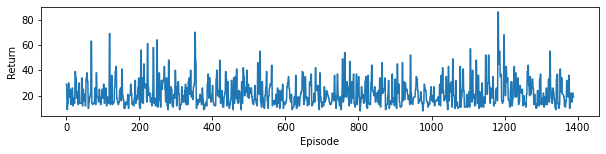

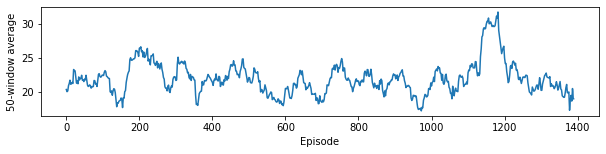

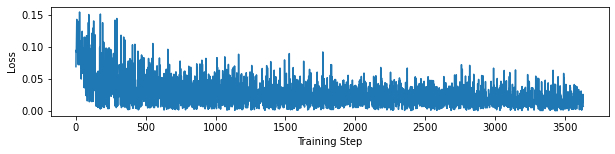

KeyboardInterrupt: 

In [499]:
#Run another agent
#agent1 = Agent_RAM('210331_1', env1, atari_action_space)
agent1.epsilon = 1.0
agent1.epsilon_max = 1.0
agent1.epsilon_min = 0.05
agent1.epsilon_lag = 1
agent1.annealing_time = 1000000
agent1.len_of_episode = 10000
agent1.gamma = 0.99
agent1.max_memory_len = 1000000
agent1.batch_size = 32
agent1.steps_per_update = 4
agent1.reward_scaler = 0.002
agent1.target_update = 1000
agent1.window = 50
agent1.episode(100000)
#LR is 0.0001

#print ('Epsilon is at ', agent1.epsilon, ' as of step ', agent1.steps_taken)
#plt.figure(figsize=(10,2))
#plt.plot(np.arange(len(agent1.episodic_return)), agent1.episodic_return)
#plt.xlabel('Episode')
#plt.ylabel('Return')
#plt.show()


#plt.figure(figsize=(10,2))
#plt.plot(np.arange(len(agent1.sliding_average(agent1.episodic_return, agent1.window))), agent1.sliding_average(agent1.episodic_return, agent1.window))
#plt.xlabel('Episode')
#plt.ylabel(str(agent1.window)+'-window average')
#plt.show()

#plt.figure(figsize=(10,2))
#plt.plot(np.arange(len(agent1.loss_history)), agent1.loss_history)
#plt.xlabel('Training Step')
#plt.ylabel('Loss')
#plt.show()

Epsilon is at  1.0  as of step  90180


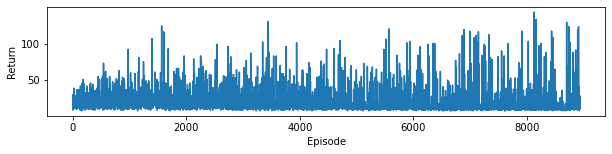

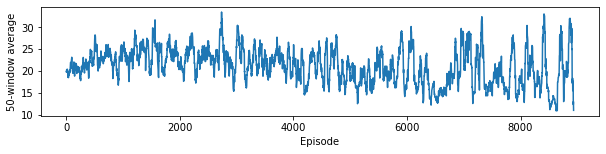

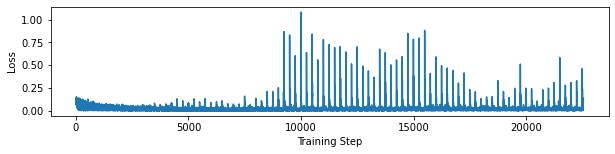

In [498]:
agent = Agent_RAM('210331_1', env1, atari_action_space)
agent.epsilon = 1.0
agent.epsilon_max = 1.0
agent.epsilon_min = 0.05
agent.epsilon_lag = 1
agent.annealing_time = 100000
agent.len_of_episode = 10000
agent.gamma = 0.99
agent.max_memory_len = 1000000
agent.batch_size = 32
agent.steps_per_update = 4
agent.reward_scaler = 0.002
agent.target_update = 1000
agent.window = 50
#agent.episode(10000)
#LR is 0.0001

print ('Epsilon is at ', agent.epsilon, ' as of step ', agent.steps_taken)
plt.figure(figsize=(10,2))
plt.plot(np.arange(len(agent.episodic_return)), agent.episodic_return)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

plt.figure(figsize=(10,2))
plt.plot(np.arange(len(agent.sliding_average(agent.episodic_return, agent.window))), agent.sliding_average(agent.episodic_return, agent.window))
plt.xlabel('Episode')
plt.ylabel(str(agent.window)+'-window average')
plt.show()

plt.figure(figsize=(10,2))
plt.plot(np.arange(len(agent.loss_history)), agent.loss_history)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.show()

Epsilon is at  0.05  as of step  101084


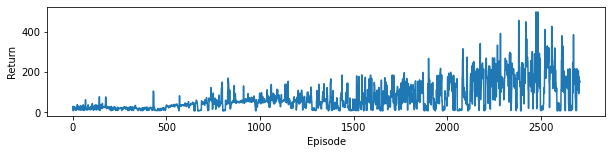

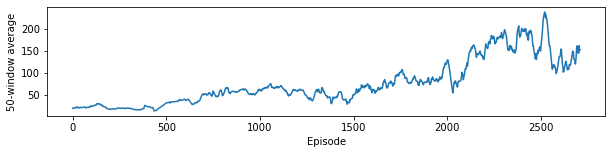

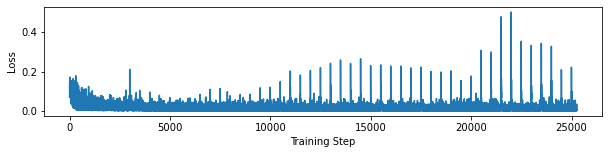

In [ ]:
#agent = Agent_RAM('210331_1', env1, atari_action_space)
agent.epsilon = 1.0
agent.epsilon_max = 1.0
agent.epsilon_min = 0.05
agent.epsilon_lag = 1000
agent.annealing_time = 1000
agent.len_of_episode = 10000
agent.gamma = 0.99
agent.max_memory_len = 1000000
agent.batch_size = 32
agent.steps_per_update = 4
agent.reward_scaler = 0.002
agent.target_update = 2000
agent.window = 50
agent.episode(10000)
#LR is 0.0001

clear_output()
print ('Epsilon is at ', agent.epsilon, ' as of step ', agent.steps_taken)
plt.figure(figsize=(10,2))
plt.plot(np.arange(len(agent.episodic_return)), agent.episodic_return)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

plt.figure(figsize=(10,2))
plt.plot(np.arange(len(agent.sliding_average(agent.episodic_return, agent.window))), agent.sliding_average(agent.episodic_return, agent.window))
plt.xlabel('Episode')
plt.ylabel(str(agent.window)+'-window average')
plt.show()

plt.figure(figsize=(10,2))
plt.plot(np.arange(len(agent.loss_history)), agent.loss_history)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.show()

Epsilon is at  0.1  as of step  23820


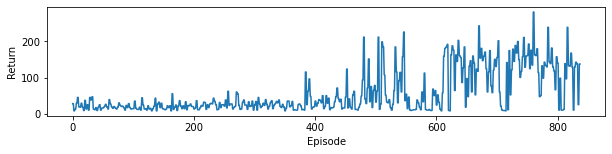

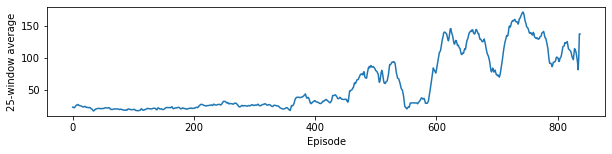

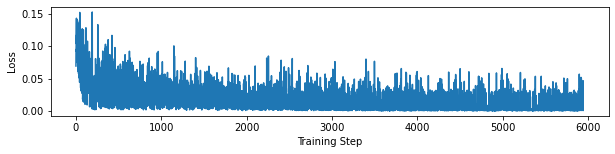

KeyboardInterrupt: 

In [489]:
agent = Agent_RAM('210331_1', env1, atari_action_space)
agent.epsilon = 1.0
agent.epsilon_max = 1.0
agent.epsilon_min = 0.1
agent.epsilon_lag = 1
agent.annealing_time = 10000
agent.len_of_episode = 10000
agent.gamma = 0.99
agent.max_memory_len = 10000
agent.batch_size = 32
agent.steps_per_update = 4
agent.reward_scaler = 0.002
agent.target_update = 2000
agent.episode(10000000)
#LR is 0.0001

Epsilon is at  1.0  as of step  28


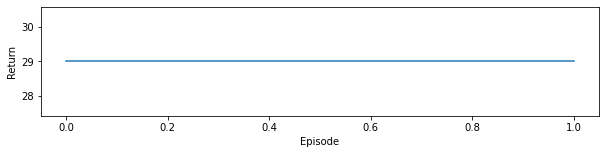

NameError: name 'n' is not defined

<Figure size 720x144 with 0 Axes>

In [483]:
agent = Agent_RAM('210331_1', env1, atari_action_space)
agent.epsilon = 1.0
agent.epsilon_max = 1.0
agent.epsilon_min = 0.1
agent.epsilon_lag = 1
agent.annealing_time = 1
agent.len_of_episode = 10000
agent.gamma = 0.99
agent.max_memory_len = 10000
agent.batch_size = 32
agent.steps_per_update = 4
agent.reward_scaler = 0.002
agent.target_update = 1000
agent.episode(10000000)


In [453]:
agent = Agent_RAM('210331_1', env1, atari_action_space)

Epsilon is at  0.1  as of step  24916


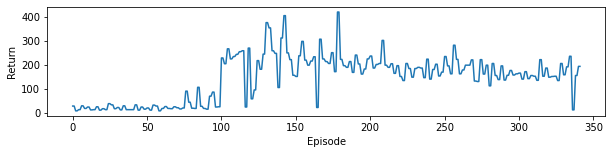

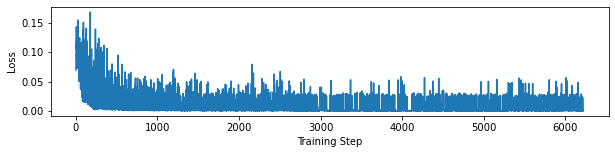

KeyboardInterrupt: 

In [455]:
agent.epsilon = 1.0
agent.epsilon_max = 1.0
agent.epsilon_min = 0.05
agent.epsilon_lag = 500
agent.annealing_time = 1000
agent.len_of_episode = 10000
agent.gamma = 0.99
agent.max_memory_len = 10000
agent.batch_size = 32
agent.steps_per_update = 4
agent.reward_scaler = 0.002
agent.target_update = 2000
agent.episode(10000000)


In [ ]:
agent = Agent_RAM('210331_1', env1, atari_action_space)
#agent = Agent_4Frame('210228_1', env1, atari_action_space)

Epsilon is at  0.21560300000000004  as of step  734500


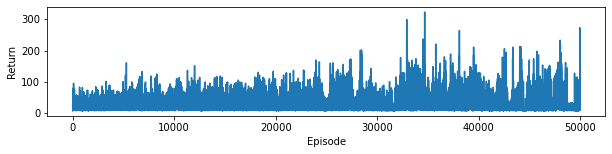

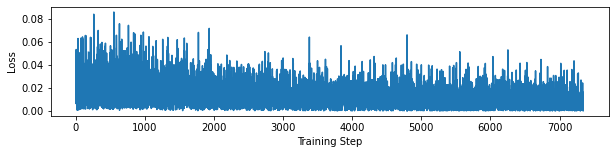

KeyboardInterrupt: 

In [172]:
agent.epsilon = 1.0
agent.epsilon_max = 1.0
agent.epsilon_min = 0
agent.epsilon_lag = 50000
agent.annealing_time = 1000000
agent.len_of_episode = 10000
agent.gamma = 0.70
agent.max_memory_len = 1000000
agent.batch_size = 32
agent.steps_per_update = 100
agent.reward_scaler = 0.01
agent.episode(10000000)
#No layer normalization


Epsilon is at  0.0  as of step  1125100


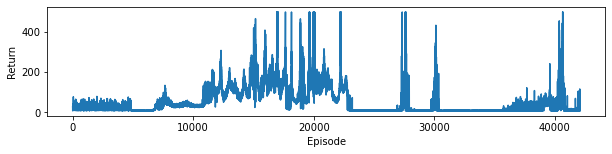

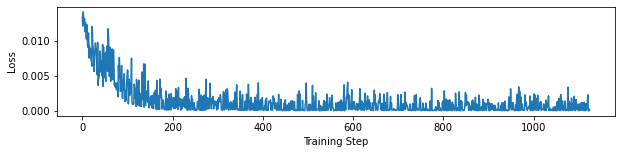

KeyboardInterrupt: 

In [196]:
agent = Agent_RAM('210331_1', env1, atari_action_space)
agent.epsilon = 1.0
agent.epsilon_max = 1.0
agent.epsilon_min = 0
agent.epsilon_lag = 50000
agent.annealing_time = 10000
agent.len_of_episode = 10000
agent.gamma = 0.99
agent.max_memory_len = 1000000
agent.batch_size = 32
agent.steps_per_update = 1000
agent.reward_scaler = 1
agent.episode(10000000)
#Batch was normalized to between -1 and 1. 

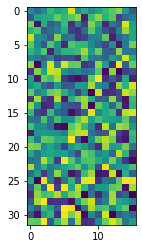

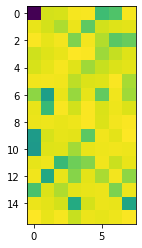

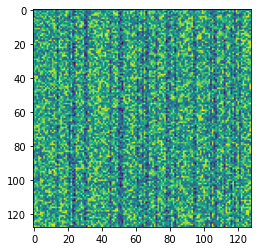

In [341]:
plt.figure()
plt.imshow(np.reshape(agent.target.toymodel.get_weights()[0], (32,16)))
plt.figure()
plt.imshow(np.reshape(agent.target.toymodel.get_weights()[1], (16,8)))
plt.figure()
plt.imshow(np.reshape(agent.target.toymodel.get_weights()[2], (128,128)))

In [342]:
future_rewards = agent.behavior.toymodel.predict(np.array(agent.next_state_history[:32]))
updated_q_values = agent.reward_history[:32] + agent.gamma * tf.reduce_max(future_rewards)

array([ 1.,  1.,  1., ...,  1.,  1., -1.])

In [339]:
updated_q_values

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([383.90024, 383.90024, 383.90024, 383.90024, 383.90024, 383.90024,
       383.90024, 383.90024, 383.90024, 383.90024, 383.90024, 383.90024,
       383.90024, 383.90024, 383.90024, 383.90024, 383.90024, 383.90024,
       383.90024, 383.90024, 383.90024, 383.90024, 383.90024, 383.90024,
       383.90024, 383.90024, 383.90024, 383.90024, 381.90024, 383.90024,
       383.90024, 383.90024], dtype=float32)>